# Import libraries

In [59]:
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import PIL.Image
import numpy as np

In [60]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Dataset preprocessing

In [61]:
dataset_path = '../dataset/helmet_classify_img'
os.listdir(dataset_path)

['helmet', 'no_helmet']

In [62]:
ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(256, 256),
    color_mode='rgb',
    batch_size=10,
    shuffle=True,
)

Found 351 files belonging to 2 classes.


In [63]:
ds_iter = ds.as_numpy_iterator()
batch = ds_iter.next()
batch[1] # 10 images of 256x256x3

array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

## Visualize images and classes

In [64]:
batch = ds_iter.next()

In [65]:
class_names = ds.class_names
class_names

['helmet', 'no_helmet']

In [66]:
def visualize_batch(batch):
    fig, ax = plt.subplots(ncols=5, figsize=(20, 20))
    for idx, im in enumerate(batch[0][:5]):
        ax[idx].imshow(im)
        ax[idx].title.set_text(batch[1][idx])

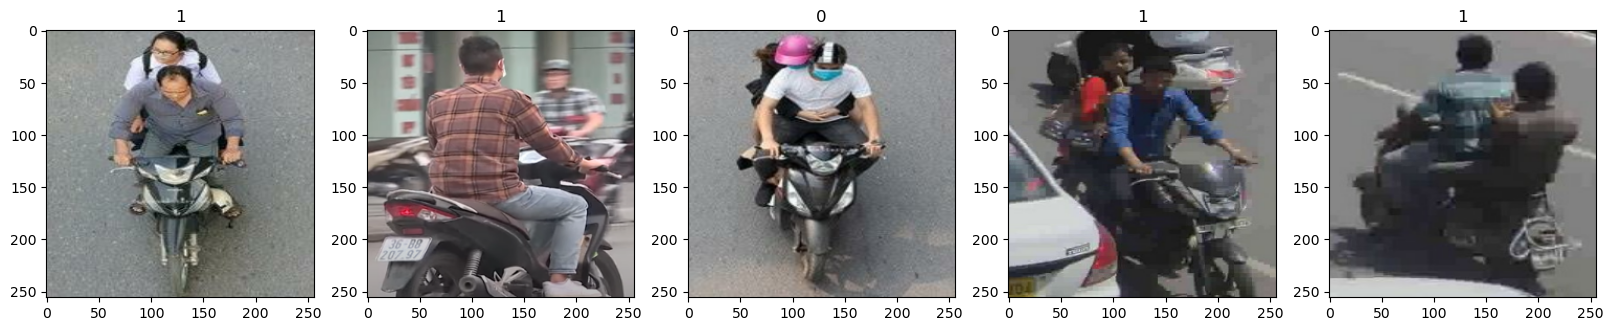

In [67]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 20))
for idx, im in enumerate(batch[0][:5]):
    ax[idx].imshow(im.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scaling images

In [68]:
batch[0].max()

255.0

In [69]:
ds = ds.map(lambda x,y: (x/255,y))

In [70]:
scaled_batch_iter = ds.as_numpy_iterator()

In [71]:
scaled_batch = scaled_batch_iter.next()
scaled_batch[0].max()

1.0

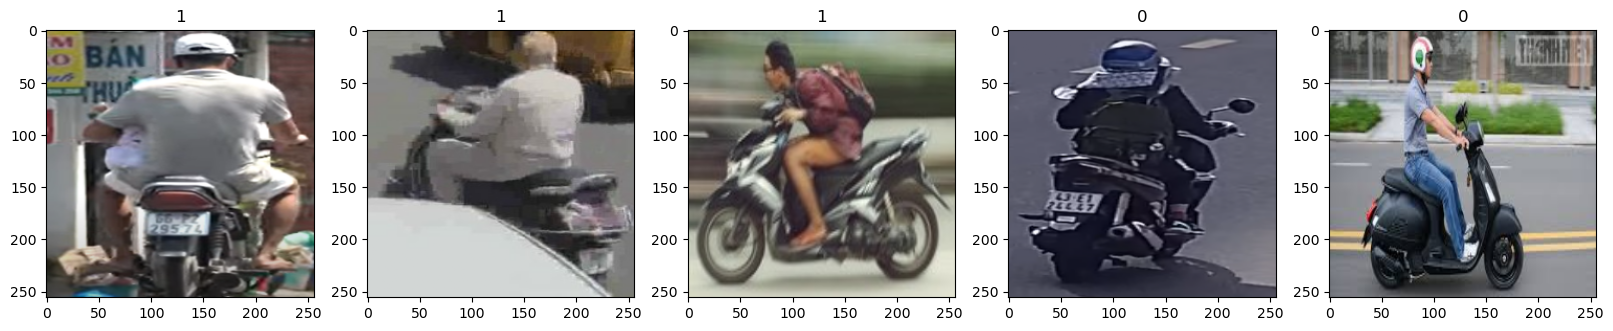

In [72]:
visualize_batch(scaled_batch)

## Augmentation for  more data

In [73]:
from tensorflow.image import stateless_random_contrast, stateless_random_brightness, stateless_random_saturation, stateless_random_flip_left_right
from tensorflow.random import Generator

In [74]:
def show_diff(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

In [75]:
rng = Generator.from_seed(123, alg='philox')
def augment(image_label, seed):
    image, label = image_label
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    
    image = stateless_random_brightness(image, max_delta=0.2, seed=new_seed)
    image = stateless_random_contrast(image, 0.5, 2.0, seed=new_seed)
    image = stateless_random_flip_left_right(image, seed=new_seed)
    image = stateless_random_saturation(image, 0.75, 1.25, seed=new_seed)
    return image, label

def make_seed_and_augment(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

### Visualizing random augmentation effect

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


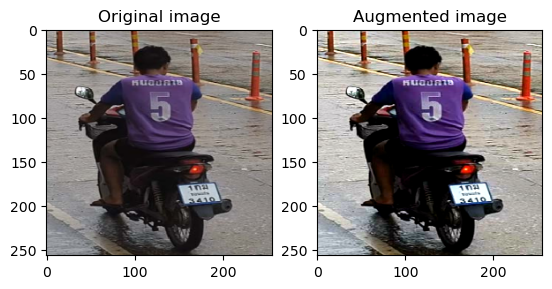

In [76]:
first_img = scaled_batch_iter.next()
augment_img = make_seed_and_augment(first_img[0][0], first_img[1][0])[0]
show_diff(first_img[0][0], augment_img)

## Splitting train-val-test

In [77]:
len(ds)

36

In [78]:
train_size = int(len(ds) * .7)
val_size = int(len(ds) * .2) + 1
test_size = int(len(ds) * .1)

In [79]:
train_size + val_size + test_size

36

In [80]:
train_set = ds.take(train_size)
val_set = ds.skip(train_size).take(val_size)
test_set = ds.skip(train_size + val_size).take(test_size)

### Apply on train set

In [81]:
aug_train = train_set.map(make_seed_and_augment)

In [82]:
train_set = train_set.concatenate(aug_train)

In [83]:
aug_iter = train_set.as_numpy_iterator()

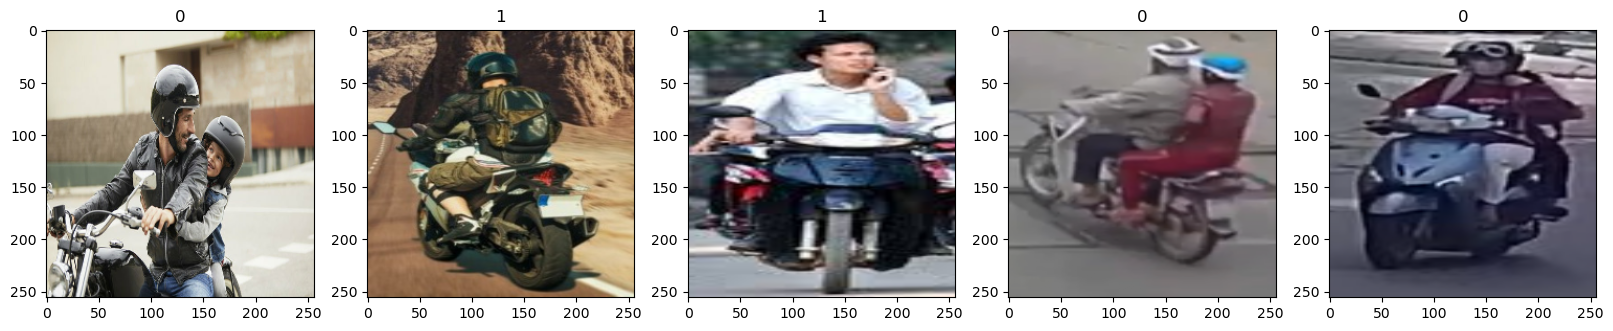

In [84]:
aug_train_batch = aug_iter.next()
visualize_batch(aug_train_batch)

In [85]:
len(train_set)

50

In [86]:
val_iter = val_set.as_numpy_iterator()

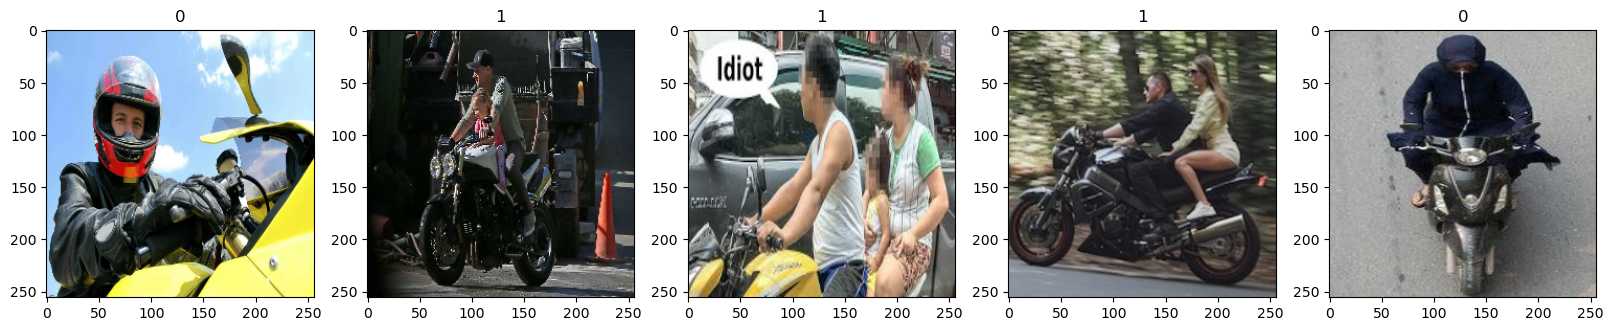

In [87]:
val_batch = val_iter.next()
visualize_batch(val_batch)

In [88]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)

# Model (CNN)

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

In [112]:
model = Sequential()

In [113]:
model.add(Conv2D(8, (3,3), 1, activation="relu", kernel_initializer='he_normal', input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (5,5), 1, activation="relu"))
model.add(MaxPooling2D(2,2))


model.add(Flatten())

model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))


In [114]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3, decay=0.25)

In [115]:
model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics="accuracy")

In [116]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 58, 58, 32)        12832     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 29, 29, 32)      

In [117]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0000001
)

In [118]:
history = model.fit(train_set, epochs=25, validation_data=val_set, callbacks=[lr_callback])

Epoch 1/25


50/50 [==============================] - 2s 19ms/step - loss: 1.0758 - accuracy: 0.5620 - val_loss: 0.6851 - val_accuracy: 0.5375 - lr: 0.0050
Epoch 2/25
50/50 [==============================] - 1s 15ms/step - loss: 0.6561 - accuracy: 0.5940 - val_loss: 0.6784 - val_accuracy: 0.5250 - lr: 0.0050
Epoch 3/25
50/50 [==============================] - 1s 14ms/step - loss: 0.6372 - accuracy: 0.6080 - val_loss: 0.6695 - val_accuracy: 0.5750 - lr: 0.0050
Epoch 4/25
50/50 [==============================] - 1s 15ms/step - loss: 0.6166 - accuracy: 0.6540 - val_loss: 0.6573 - val_accuracy: 0.5625 - lr: 0.0050
Epoch 5/25
50/50 [==============================] - 1s 15ms/step - loss: 0.5932 - accuracy: 0.7540 - val_loss: 0.6402 - val_accuracy: 0.6125 - lr: 0.0050
Epoch 6/25
50/50 [==============================] - 1s 15ms/step - loss: 0.5679 - accuracy: 0.7800 - val_loss: 0.6202 - val_accuracy: 0.6875 - lr: 0.0050
Epoch 7/25
50/50 [==============================] - 1s 15ms/step - loss: 0.5421 - accur

## Training monitoring

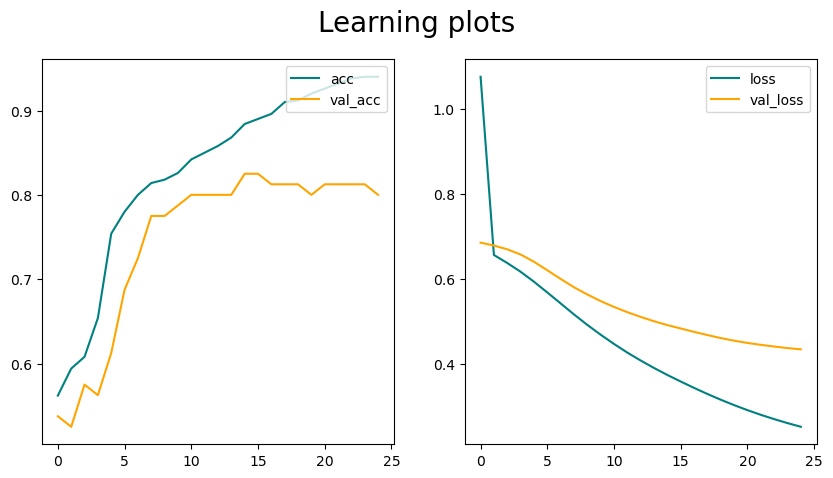

In [119]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='teal', label='acc')
plt.plot(history.history['val_accuracy'], color='orange', label='val_acc')

plt.legend(loc="upper right")

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')

fig.suptitle('Learning plots', fontsize=20)
plt.legend(loc="upper right")
plt.show()


## Evaluating

In [120]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [121]:
precision_score = Precision()
recall_score = Recall()
acc = BinaryAccuracy()

In [122]:
len(test_set)

3

In [123]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision_score.update_state(y, yhat)
    recall_score.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 30ms/step


In [124]:
print(f"Precision: {precision_score.result().numpy()}, Recall: {recall_score.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 1.0, Recall: 0.75, Accuracy: 0.8571428656578064


In [160]:
sample = test_set.as_numpy_iterator()

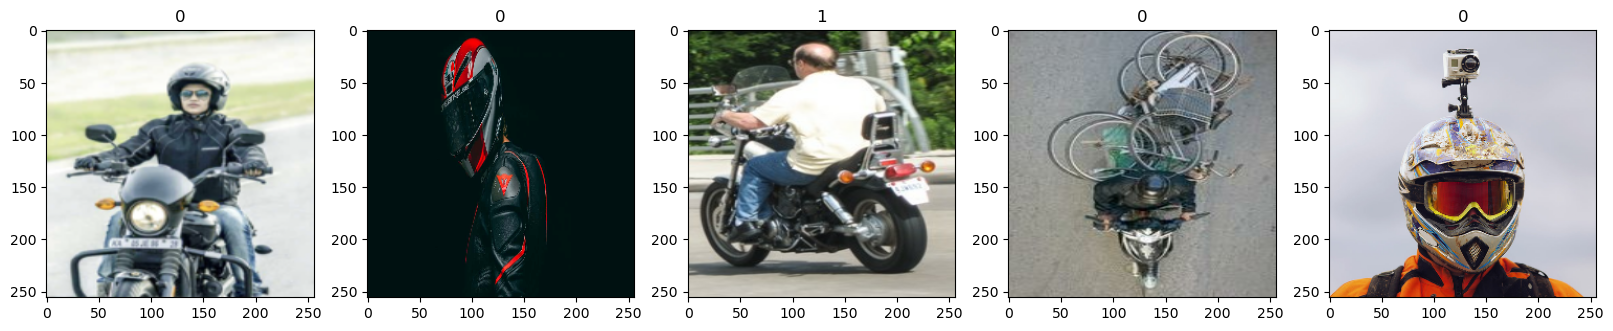

In [161]:
sample = sample.next()
visualize_batch(sample)

In [162]:
x = sample[0]
y = sample[1]
yhat = np.squeeze((model.predict(x) > 0.5).astype("int32"))
print(y, yhat)

1/1 [==============================] - 0s 28ms/step
[0 0 1 0 0 1 0 0 1 0] [0 0 1 0 0 1 1 0 0 0]


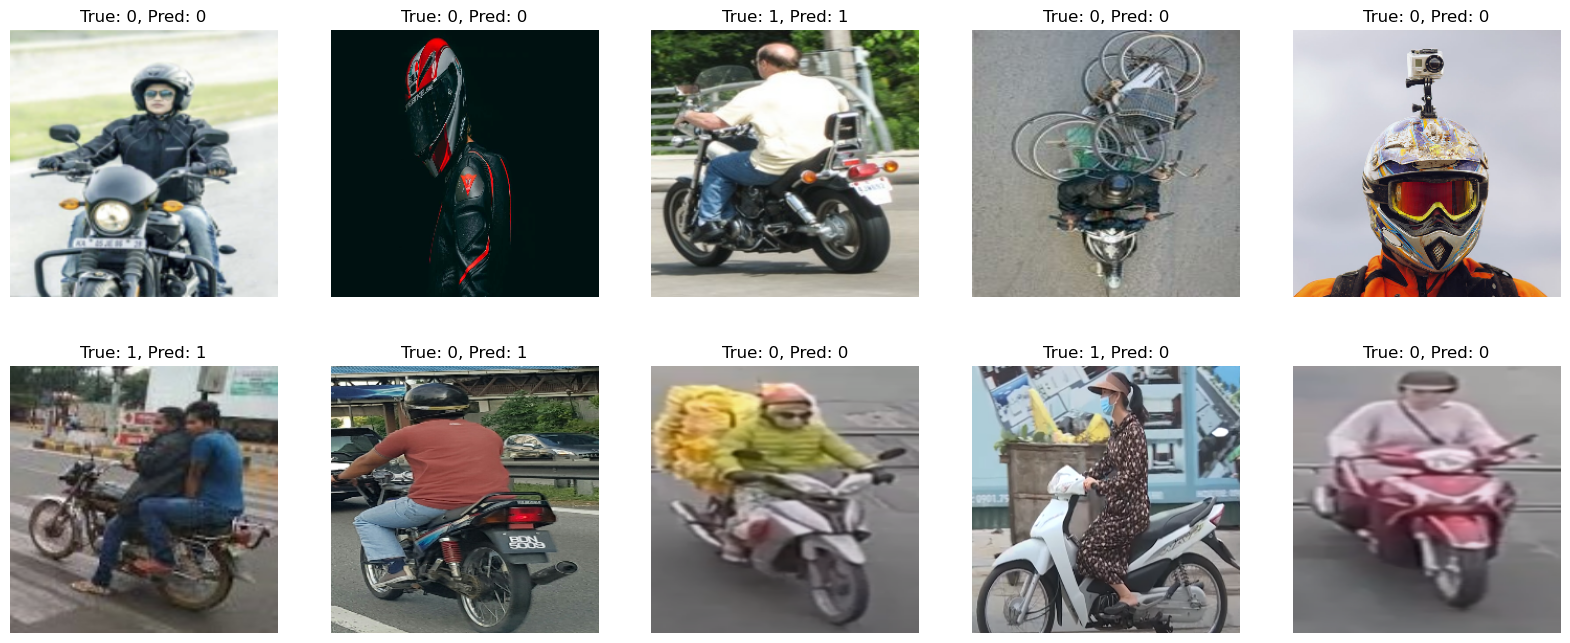

In [163]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))
for idx, ax in enumerate(axes.flatten()[:10]):
    ax.imshow(x[idx])
    ax.title.set_text(f"True: {y[idx]}, Pred: {yhat[idx]}")
    ax.axis('off')


## Save model at /checkpoints

In [164]:
from tensorflow.keras.models import load_model, save_model

In [166]:
model.save(os.path.join('../checkpoints', '14_1/helmet.h5'))